In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib.pyplot import figure
import scipy.io
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import seaborn as sns

In [ ]:
files.upload()
mat = scipy.io.loadmat('data.mat')

mat

In [ ]:
array = mat['X']

In [ ]:
array.shape

(70128, 4, 5)

In [ ]:
# creating a DataFrame from the given dataset
city={0: [], 1: [], 2: [],3:[]}
for i in range(4):
    for j in range(array.shape[0]):
        city[i].append(array[j][:][i])       

In [ ]:
df = pd.concat([pd.DataFrame(city[0]), pd.DataFrame(city[1]),pd.DataFrame(city[2]),pd.DataFrame(city[3])], axis=1)

In [ ]:
df.columns = ["ws1","wd1","t1","d1","a1","ws2","wd2","t2","d2","a2","ws3","wd3","t3","d3","a3","ws4","wd4","t4","d4","a4"]

In [ ]:
df = df[["ws1","wd1","t1","d1","a1","ws2","wd2","t2","d2","a2","ws3","wd3","t3","d3","a3","ws4","wd4","d4","a4","t4"]]

In [ ]:
df

,ws1,wd1,t1,d1,a1,ws2,wd2,t2,d2,a2,ws3,wd3,t3,d3,a3,ws4,wd4,d4,a4,t4
0,60,260,35,32,10185,40,240,52,48,10223,30,230,13,11,10229,30,220,8,10237,9
1,60,260,36,33,10183,40,280,50,44,10220,30,230,15,14,10226,30,220,7,10235,8
2,60,260,37,34,10181,30,270,49,41,10217,40,240,15,13,10223,30,220,8,10232,8
3,50,260,38,35,10174,40,280,50,38,10213,30,240,16,14,10218,30,230,10,10226,10
4,50,260,39,36,10169,40,280,51,38,10211,30,230,14,13,10216,30,230,12,10224,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,60,250,86,63,10301,40,240,82,69,10332,30,250,85,74,10338,30,210,73,10342,77
70124,50,250,82,65,10299,40,240,79,71,10328,40,260,82,66,10336,30,250,73,10338,80
70125,60,240,82,63,10291,40,240,82,69,10325,40,250,76,68,10332,30,240,71,10335,78
70126,60,250,81,61,10286,50,260,87,55,10321,40,260,76,67,10333,30,260,65,10334,78


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# concatenating the columns
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [ ]:
#lookback period analysis

dict1 = dict.fromkeys([1,2,4,8,16,32,64,128,256], 0)

for i in dict1:
    values = df.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, i, 1)
    reframed=pd.concat([reframed.iloc[:,0:20], reframed.iloc[:,-1]], axis=1)
    values = reframed.values
    frac = int(0.9*reframed.values.shape[0])
    train = values[:frac, :]
    test = values[frac:, :]
    
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    mae=mean_absolute_error(inv_y, inv_yhat)
    dict1[i]=mae

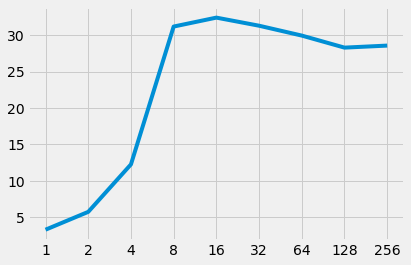

In [ ]:
plt.plot(list(dict1.values()))
plt.xticks(np.arange(9), [*dict1])
plt.set_title("MAE for various lookbacks")
plt.ylabel("MAE")
plt.xlabel("Lookback values")
plt.show()

In [ ]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed=pd.concat([reframed.iloc[:,0:20], reframed.iloc[:,-1]], axis=1)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.272727   0.722222   0.411765   0.544828   0.646091   0.190476   
2   0.272727   0.722222   0.413603   0.547126   0.643347   0.190476   
3   0.272727   0.722222   0.415441   0.549425   0.640604   0.142857   
4   0.227273   0.722222   0.417279   0.551724   0.631001   0.190476   
5   0.227273   0.722222   0.419118   0.554023   0.624143   0.190476   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var12(t-1)  var13(t-1)  \
1   0.666667   0.411877   0.554987    0.700258  ...    0.638889    0.370766   
2   0.777778   0.408046   0.544757    0.696383  ...    0.638889    0.374332   
3   0.750000   0.406130   0.537084    0.692507  ...    0.666667    0.374332   
4   0.777778   0.408046   0.529412    0.687339  ...    0.666667    0.376114   
5   0.777778   0.409962   0.529412    0.684754  ...    0.638889    0.372549   

   var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  \
1    0.514673    0.70

In [ ]:
# split into train and test sets
values = reframed.values
frac = int(0.997615*reframed.values.shape[0])
train = values[:frac, :]
test = values[frac:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(69959, 1, 20) (69959,) (168, 1, 20) (168,)


Epoch 1/10
972/972 [==============================] - 7s 5ms/step - loss: 0.0337 - val_loss: 0.0242
Epoch 2/10
972/972 [==============================] - 5s 5ms/step - loss: 0.0180 - val_loss: 0.0157
Epoch 3/10
972/972 [==============================] - 5s 5ms/step - loss: 0.0158 - val_loss: 0.0135
Epoch 4/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0153 - val_loss: 0.0117
Epoch 5/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0148 - val_loss: 0.0115
Epoch 6/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0145 - val_loss: 0.0110
Epoch 7/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0144 - val_loss: 0.0111
Epoch 8/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0141 - val_loss: 0.0104
Epoch 9/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0141 - val_loss: 0.0108
Epoch 10/10
972/972 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0104

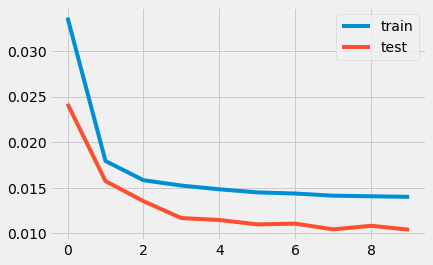

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
test_X.shape

(168, 1, 20)

In [ ]:
# make prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MAE
mae=mean_absolute_error(inv_y, inv_yhat)
print(mae)

2.2907903


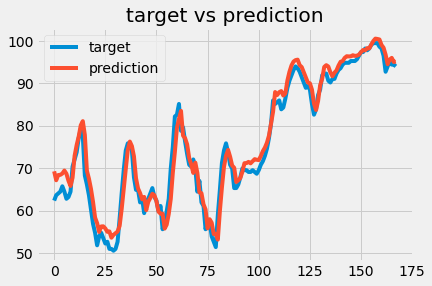

In [ ]:
plt.title('target vs prediction')
p1=plt.plot(inv_y)
p2=plt.plot(inv_yhat)
plt.legend((p1[0], p2[0]), ('target', 'prediction'))
plt.show()

In [ ]:
# Finding out feature importance
featimp=[]

for i in range(19):
  df1=df
  df1=df1.drop(df1.columns[[0]], axis=1)
  values = df1.values
  values = values.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  reframed = series_to_supervised(scaled, 1, 1)
  reframed=pd.concat([reframed.iloc[:,0:19], reframed.iloc[:,-1]], axis=1)
  values = reframed.values
  frac = int(0.9*reframed.values.shape[0])
  train = values[:frac, :]
  test = values[frac:, :]
    
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
    
  history = model.fit(train_X, train_y, epochs=5, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
      
  inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  mae=mean_absolute_error(inv_y, inv_yhat)
  featimp.append(mae)

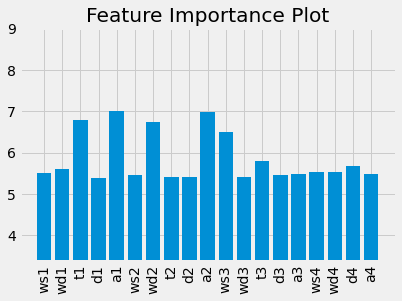

In [ ]:
plt.title('Feature Importance Plot')
plt.bar(np.arange(19),featimp)
plt.xticks(np.arange(19), df.columns)
plt.xticks(rotation = 90)
plt.ylim(min(featimp)-2, max(featimp)+2)
plt.show()